# COMP47650–Deep Learning Project
## Traffic signs classification
Zairui Zhang 19209905

Datasource from Kaggle: https://www.kaggle.com/datasets/valentynsichkar/traffic-signs-preprocessed?select=datasets_preparing.py  

In [1]:
import pandas as pd
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator,array_to_img
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import imgaug as ia
from imgaug import augmenters as iaa
from tensorflow.keras import layers, models

In [2]:
# check tensorflow version
tf.__version__

'2.10.0'

In [3]:
# check if GPU is available or not to acclerate training
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available, using CPU instead.")

GPU is available.


Load Data into train, valid and test list

In [4]:
train_data = pd.read_pickle("train.pickle")
valid_data = pd.read_pickle("valid.pickle")
test_data = pd.read_pickle("test.pickle")

In [5]:
# check keys in the data
train_data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [6]:
# separate features and labels
X_train = train_data['features']
y_train = train_data['labels']
X_valid = valid_data['features']
y_valid = valid_data['labels']
X_test = test_data['features']
y_test = test_data['labels']

In [7]:
# one hot encoding
y_train_onehot = to_categorical(y_train)
y_valid_onehot = to_categorical(y_valid)
y_test_onehot = to_categorical(y_test)

In [41]:
# check shape of the data
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [11]:
# read the class names
class_names = pd.read_csv("label_names.csv")
class_names 

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


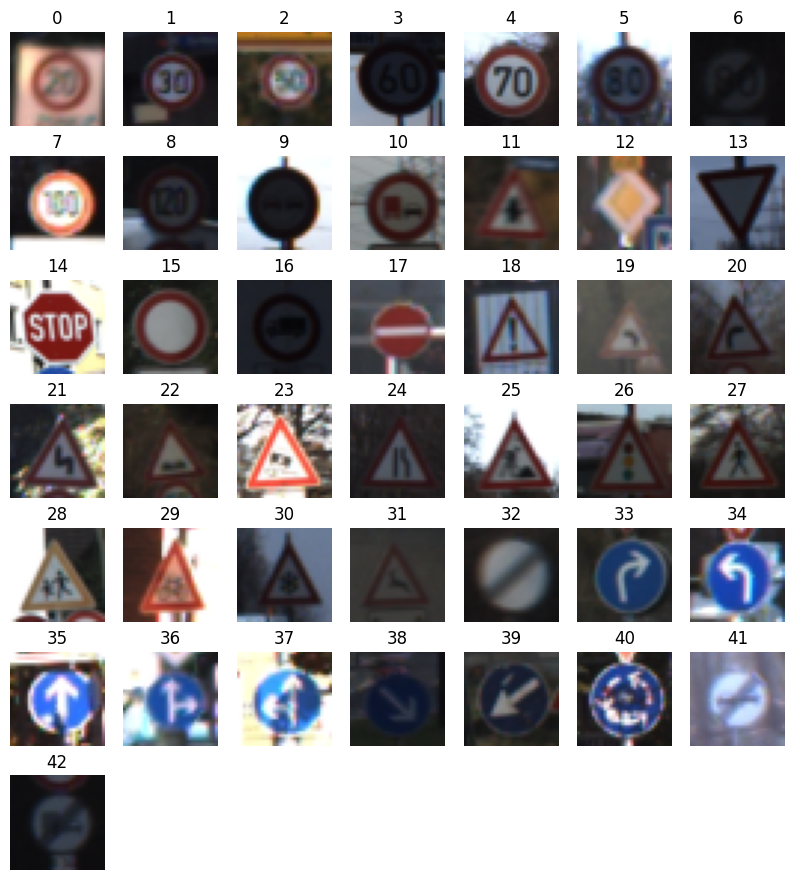

In [12]:
# select 43 classes examples
num_classes = 43
columns = 5
plt.figure(figsize=(10, 11))
for i in range(num_classes):
    plt.subplot(7, 7, i+1)
    x, y = X_train[y_train == i], y_train[y_train == i]
    plt.imshow(x[np.random.randint(x.shape[0])])
    plt.title(str(i))
    plt.axis('off')
plt.show()

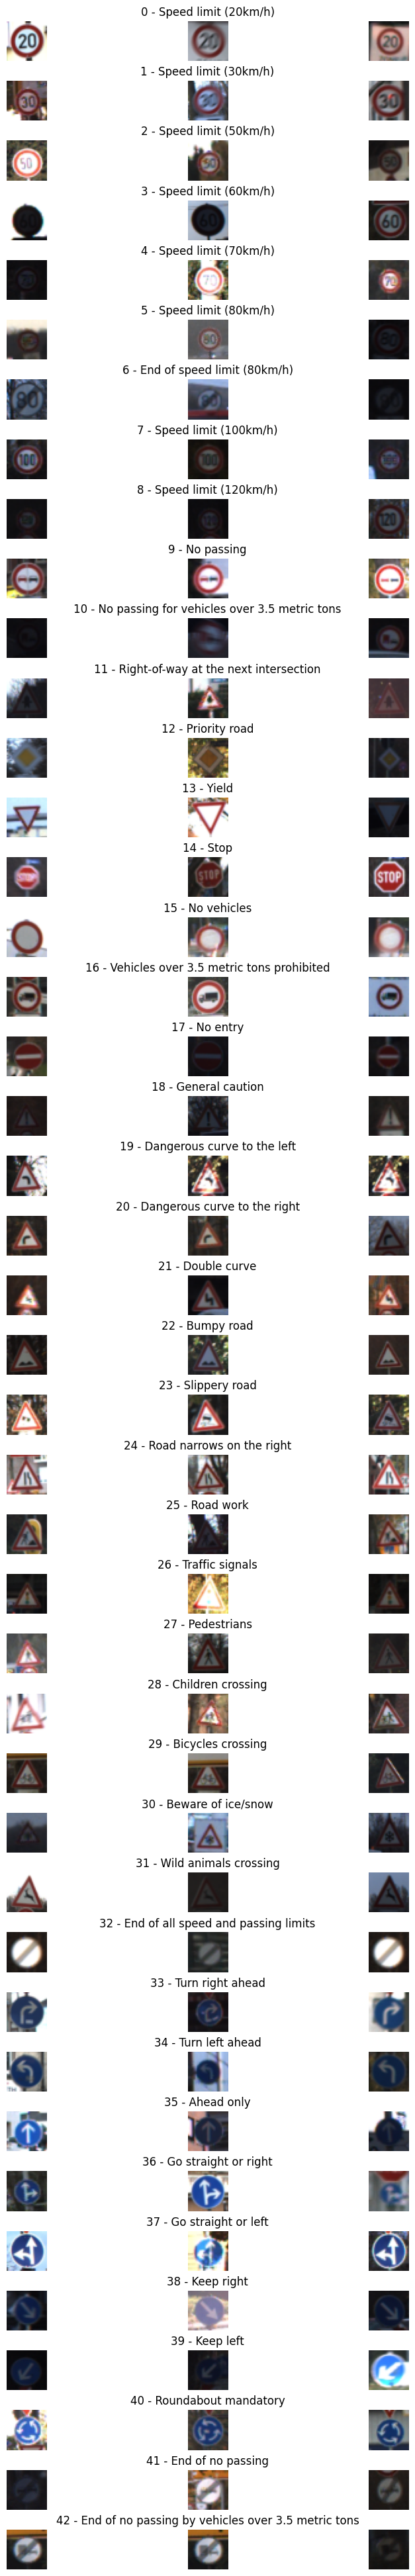

In [13]:
# select 3 examples from each class
samples=[]
num_classes = 43
columns = 3
figs, axs = plt.subplots(nrows=num_classes, ncols=columns, figsize=(10, 50))
plt.subplots_adjust(hspace=0.5)
for i in range(columns):
   for j,row in class_names.iterrows():
      example = X_train[(y_train == j)]
      axs[j][i].imshow(example[random.randint(0, len(example)-1)], cmap='gray')
      axs[j][i].axis('off')
      if i == 1:
         axs[j][i].set_title(str(j)+' - '+row['SignName'])
         samples.append(len(example))
plt.show()

### Image preprocessing

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


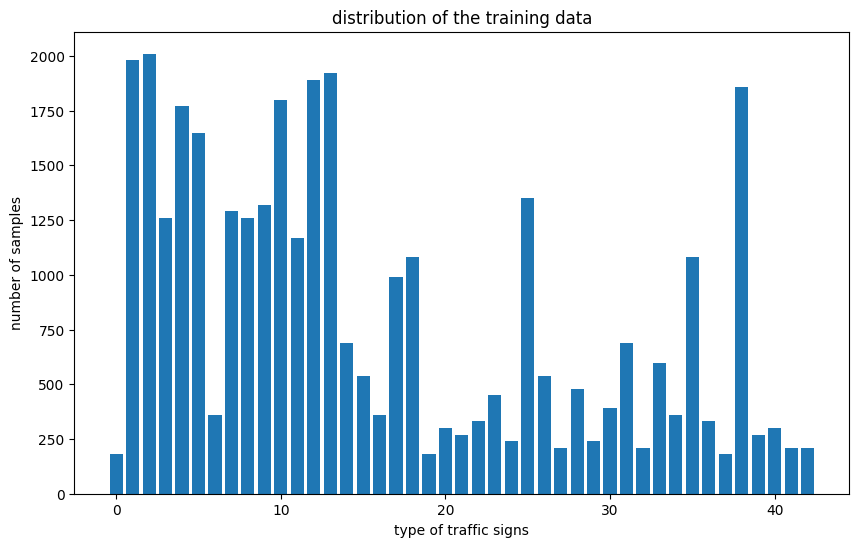

In [14]:
# distribution of the training data
print(samples)
plt.figure(figsize=(10, 6))
plt.bar(range(0, num_classes), samples)
plt.title("distribution of the training data")
plt.xlabel("type of traffic signs")
plt.ylabel("number of samples")
plt.show()

In [15]:
# Definition of the brightness_changing function, code from dataset author
def brightness_changing(image, min_brightness=0.5, max_brightness=1.5):
    """Adjust the brightness of an image."""
    image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    random_brightness = min_brightness + np.random.uniform() * (max_brightness - min_brightness)
    image_hsv[:, :, 2] = cv.normalize(image_hsv[:, :, 2] * random_brightness, None, 0, 255, cv.NORM_MINMAX)
    image_rgb = cv.cvtColor(image_hsv, cv.COLOR_HSV2RGB)
    return image_rgb

In [16]:
# randomly rotate method code from dataset author
def rotation_changing(image):
    # Defining angle range
    angle_range = 25
    # Defining angle rotation
    angle_rotation = np.random.uniform(angle_range) - angle_range / 2
    # Getting shape of image
    rows, columns, channels = image.shape
    # Implementing rotation
    # Calculating Affine Matrix
    affine_matrix = cv.getRotationMatrix2D((columns / 2, rows / 2), angle_rotation, 1)
    # Warping original image with Affine Matrix
    rotated_image = cv.warpAffine(image, affine_matrix, (columns, rows))
    # Returning rotated image
    return rotated_image

In [17]:
# apply brightness_changing and rotation_changing to random image
def random_image(x_train, y_train, y_number):
    image_indexes = np.where(y_train == y_number)
    random_index = np.random.randint(0, np.bincount(y_train)[y_number] - 1)
    return x_train[image_indexes][random_index]
def transformation_brightness_rotation(image):
    return brightness_changing(rotation_changing(image))

In [18]:
# CLASS EQUALIZATION TO REDUCE IMBALANCED DATA code from dataset author
def equalize_training_dataset(x_train, y_train):
    # Getting number of examples for every label
    number_of_examples_for_every_label = np.bincount(y_train)
    # Calculating total amount of unique labels
    number_of_labels = np.arange(len(number_of_examples_for_every_label))

    # Iterating over all number of labels
    # Showing progress ber with 'tqdm'
    for i in tqdm(number_of_labels):
        # Calculating how many examples is needed to add for current label
        # 'np.mean(number_of_examples_for_every_label)' - average number over examples for every label
        number_of_examples_to_add = int(np.mean(number_of_examples_for_every_label) * 2.5) - \
                                    number_of_examples_for_every_label[i]

        # Defining temporary arrays for collecting new images
        x_temp = []
        y_temp = []

        # Getting random image from current label
        # Transforming it and adding to the temporary arrays
        for j in range(number_of_examples_to_add):
            getting_random_image = random_image(x_train, y_train, i)
            x_temp.append(transformation_brightness_rotation(getting_random_image))
            y_temp.append(i)

        x_train = np.append(x_train, np.array(x_temp), axis=0)
        y_train = np.append(y_train, np.array(y_temp), axis=0)

    return x_train, y_train

In [19]:
X_train_equalized, y_train_equalized = equalize_training_dataset(X_train, y_train)

100%|██████████| 43/43 [00:24<00:00,  1.76it/s]


In [20]:
# check data shape after equalization
X_train_equalized.shape

(86989, 32, 32, 3)

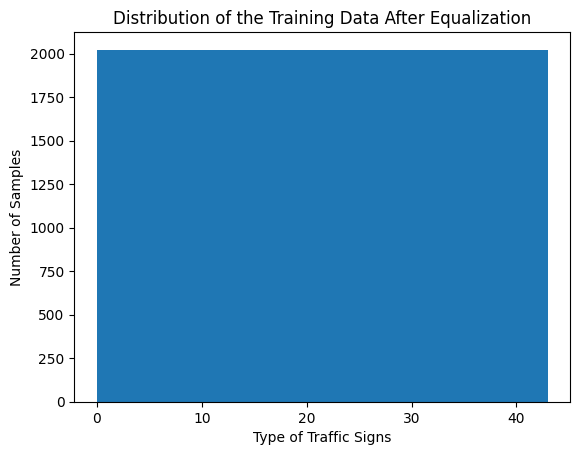

In [21]:
# plot histogram after equalization
plt.hist(y_train_equalized, bins=np.arange(43 + 1))
plt.title('Distribution of the Training Data After Equalization')
plt.xlabel('Type of Traffic Signs')
plt.ylabel('Number of Samples')
plt.show()

In [22]:
# contrast enhancement by clahe
def contrast_enhance(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
    L, a, b = cv.split(img_lab)
    clahe = cv.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    L = clahe.apply(L)
    img_lab_merge = cv.merge((L, a, b))
    return cv.cvtColor(img_lab_merge, cv.COLOR_Lab2BGR)
def apply_contrast_enhancement_to_batch(images, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Apply contrast enhancement to a batch of images."""
    enhanced_images = [contrast_enhance(img, clip_limit, tile_grid_size) for img in images]
    return np.array(enhanced_images)
X_train_contrast = apply_contrast_enhancement_to_batch(X_train_equalized)

Image Augmentation

In [23]:
datagen = ImageDataGenerator(width_shift_range=0.1, # horizontal shift
                            height_shift_range=0.1, # vertical shift
                            zoom_range=0.2, # zoom the image
                            shear_range=10, # shear angle
                            rotation_range=30.) # rotation angle
datagen.fit(X_train_contrast)

cutout = iaa.Cutout(nb_iterations=2)
change_hue_sat = iaa.AddToHueAndSaturation((-50, 50))

Image before and after preprocessing comparison

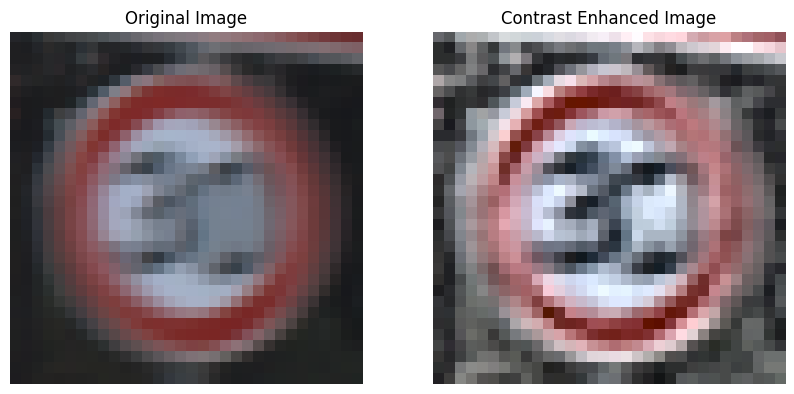

In [24]:
#randomly select an index
index = np.random.randint(0, len(X_train))

#extract the corresponding images
original_image = X_train[index]
contrast_enhanced_image = X_train_contrast[index]

#plot both images for comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(contrast_enhanced_image)
plt.title('Contrast Enhanced Image')
plt.axis('off')

plt.show()

In [25]:
# combine original and contrast enhanced images avoiding overfitting
from sklearn.utils import shuffle
y_train_equalized_onehot = to_categorical(y_train_equalized, num_classes=num_classes)
X_train_combined = np.concatenate((X_train, X_train_contrast), axis=0)
y_train_combined = np.concatenate((y_train_onehot, y_train_equalized_onehot), axis=0)
X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined)

In [26]:
print("Shape of X_train:", X_train.shape)  # Expected shape: (num_samples, 32, 32, 3)
print("Shape of y_train_onehot:", y_train_onehot.shape)  # Expected shape: (num_samples, 43)

Shape of X_train: (34799, 32, 32, 3)
Shape of y_train_onehot: (34799, 43)


## CNN created and evaluation

In [27]:
# accuracy evaluation function
def evaluate_model(model, X_test, y_test_onehot):
  test_loss, test_acc = model.evaluate(X_test,  y_test_onehot, verbose=2)
  print('\nTest accuracy:', test_acc)

In [28]:
# Loss and Accuracy plot function
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].legend(['Training', 'Validation'])
    axs[0].set_title('Loss')
    axs[0].set_xlabel('epoch')
    
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].legend(['Training', 'Validation'])
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('epoch')

In [29]:
# early stopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',  
    patience=10,          # number of epochs with no improvement after which training will be stopped
    verbose=1,         # 0: no output, 1: update messages, 2: full output
    restore_best_weights=True  # restore the best weights found during training
)

Lenet-5 classification

In [61]:
# LeNet-5 model
class LeNet5(models.Model):
    def __init__(self, n_classes, start_channels=3):
        super(LeNet5, self).__init__()
        # define the feature extractor
        self.feature_extractor = models.Sequential([
            
            layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(None, None, start_channels)),
            layers.AveragePooling2D(pool_size=(2, 2)),
            
            layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='tanh'),
            layers.AveragePooling2D(pool_size=(2, 2)),
            
            layers.Conv2D(filters=120, kernel_size=(5, 5), strides=(1, 1), activation='tanh')
        ])
        
        # define the classifier
        self.classifier = models.Sequential([
            layers.Flatten(),
            layers.Dense(84, activation='elu'),
            layers.Dense(n_classes, activation='softmax')
        ])

    def call(self, inputs):
        x = self.feature_extractor(inputs)
        return self.classifier(x)

# create an instance of the model
model1 = LeNet5(n_classes=43, start_channels=3)

# model compilation
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summary
model1.build((None, 32, 32, 3))
model1.summary()

Model: "le_net5_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, None, None, 120)   50992     
                                                                 
 sequential_6 (Sequential)   (None, 43)                13819     
                                                                 
Total params: 64,811
Trainable params: 64,811
Non-trainable params: 0
_________________________________________________________________


In [31]:
history1 = model1.fit(X_train_combined, y_train_combined, epochs=100,validation_data=(X_valid, y_valid_onehot), batch_size=256, callbacks=early_stopper)

Epoch 1/100
476/476 [==============================] - 4s 4ms/step - loss: 0.7168 - accuracy: 0.8141 - val_loss: 0.4368 - val_accuracy: 0.8762
Epoch 2/100
476/476 [==============================] - 2s 3ms/step - loss: 0.1542 - accuracy: 0.9581 - val_loss: 0.4018 - val_accuracy: 0.8932
Epoch 3/100
476/476 [==============================] - 2s 3ms/step - loss: 0.0965 - accuracy: 0.9728 - val_loss: 0.3816 - val_accuracy: 0.9007
Epoch 4/100
476/476 [==============================] - 2s 3ms/step - loss: 0.0667 - accuracy: 0.9812 - val_loss: 0.3967 - val_accuracy: 0.9041
Epoch 5/100
476/476 [==============================] - 2s 3ms/step - loss: 0.0495 - accuracy: 0.9859 - val_loss: 0.3861 - val_accuracy: 0.9093
Epoch 6/100
476/476 [==============================] - 2s 3ms/step - loss: 0.0393 - accuracy: 0.9887 - val_loss: 0.3658 - val_accuracy: 0.9204
Epoch 7/100
476/476 [==============================] - 2s 3ms/step - loss: 0.0352 - accuracy: 0.9897 - val_loss: 0.4021 - val_accuracy: 0.9116

395/395 - 0s - loss: 0.3760 - accuracy: 0.9101 - 490ms/epoch - 1ms/step

Test accuracy: 0.9101346135139465


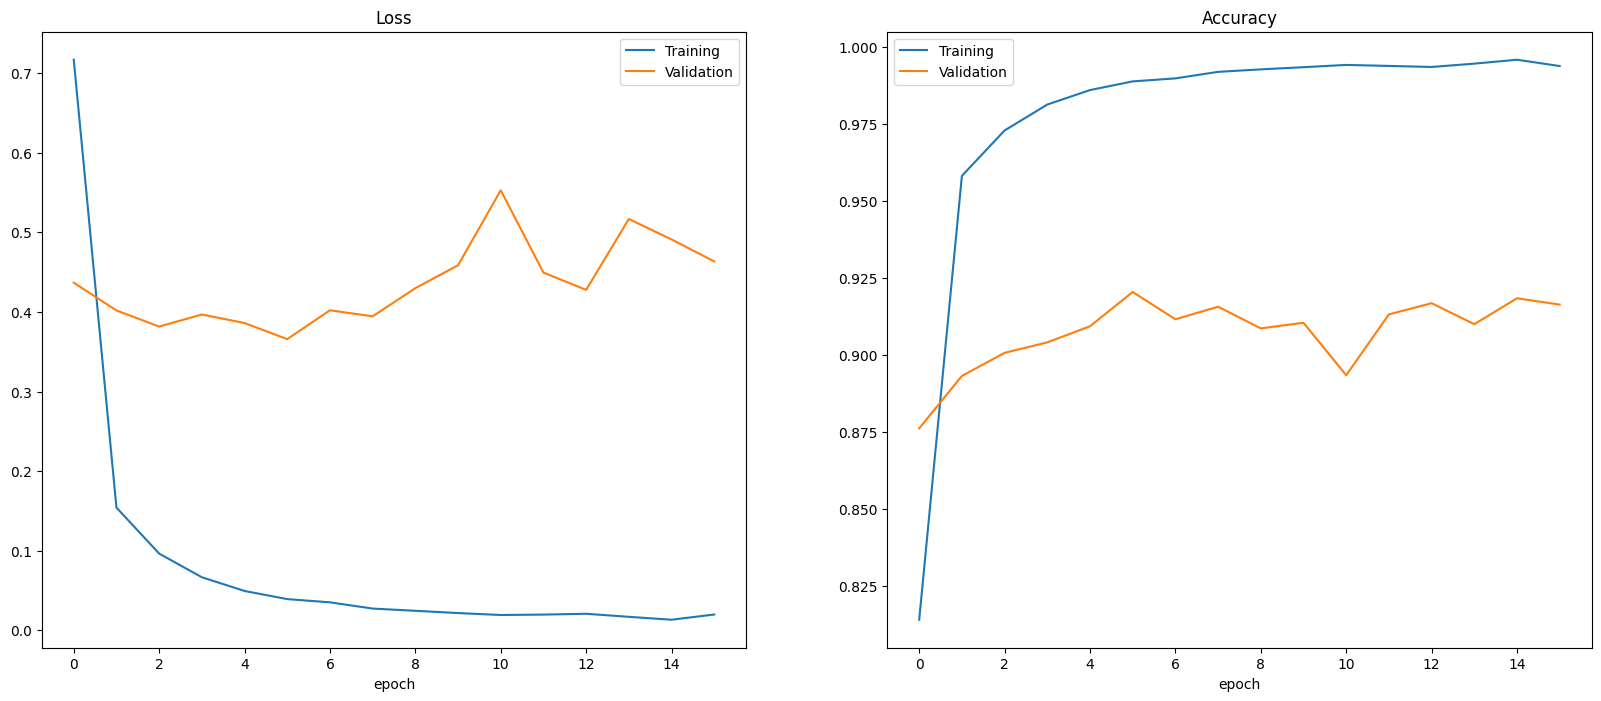

In [32]:
# model evaluation and plotting
evaluate_model(model1, X_test, y_test_onehot)
plot_history(history1)

The loss graph shows a sharp decline in training loss from the outset, leveling off at a low value quickly, which indicates rapid learning in the initial phases. However, the validation loss demonstrates more variability, suggesting some overfitting as the model learns patterns specific to the training data that do not generalize as effectively to the validation set.

On the accuracy graph, training accuracy swiftly reaches a high plateau near 100%, reflecting that the model fits the training data extremely well. In contrast, the validation accuracy exhibits fluctuations and remains significantly lower than the training accuracy, peaking around 92.5%. This discrepancy further supports the presence of overfitting, where the model's ability to generalize to unseen data is less robust than its performance on training data.

CNN model: Hyperparameter by attemption on filter sizes and learning rate(0.0001 to 0.01). Following is the best parameter after 10+ times attemptions.

In [33]:
# define the model of basic Lenet-5 architecture
# first convolutional layer
model2 = Sequential()
model2.add(Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)))
model2.add(MaxPool2D((2, 2)))
# second convolutional layer
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPool2D((2, 2)))
model2.add(Dropout(0.5))
# fully connected layer
model2.add(Flatten())
model2.add(Dense(150, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(43, activation='softmax'))

# compile the model
model2.compile(Adam(learning_rate=0.001), # optimizer
              loss='categorical_crossentropy', # loss function
              metrics=['accuracy'])
model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 2304)             

In [40]:
# save the model to disk
model2.save('CNN_model.h5')

In [34]:
# train the model
history2 = model2.fit(X_train_combined, y_train_combined, epochs=100,validation_data=(X_valid, y_valid_onehot), batch_size=256,callbacks=early_stopper)

Epoch 1/100
476/476 [==============================] - 3s 5ms/step - loss: 3.4329 - accuracy: 0.2149 - val_loss: 1.3462 - val_accuracy: 0.7007
Epoch 2/100
476/476 [==============================] - 2s 5ms/step - loss: 0.9148 - accuracy: 0.7175 - val_loss: 0.5542 - val_accuracy: 0.8689
Epoch 3/100
476/476 [==============================] - 2s 5ms/step - loss: 0.5165 - accuracy: 0.8389 - val_loss: 0.3596 - val_accuracy: 0.9141
Epoch 4/100
476/476 [==============================] - 2s 5ms/step - loss: 0.3792 - accuracy: 0.8839 - val_loss: 0.3288 - val_accuracy: 0.9172
Epoch 5/100
476/476 [==============================] - 2s 5ms/step - loss: 0.3108 - accuracy: 0.9045 - val_loss: 0.2420 - val_accuracy: 0.9404
Epoch 6/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2692 - accuracy: 0.9178 - val_loss: 0.2448 - val_accuracy: 0.9410
Epoch 7/100
476/476 [==============================] - 2s 5ms/step - loss: 0.2433 - accuracy: 0.9272 - val_loss: 0.1996 - val_accuracy: 0.9524

395/395 - 1s - loss: 0.1558 - accuracy: 0.9610 - 526ms/epoch - 1ms/step

Test accuracy: 0.9610451459884644


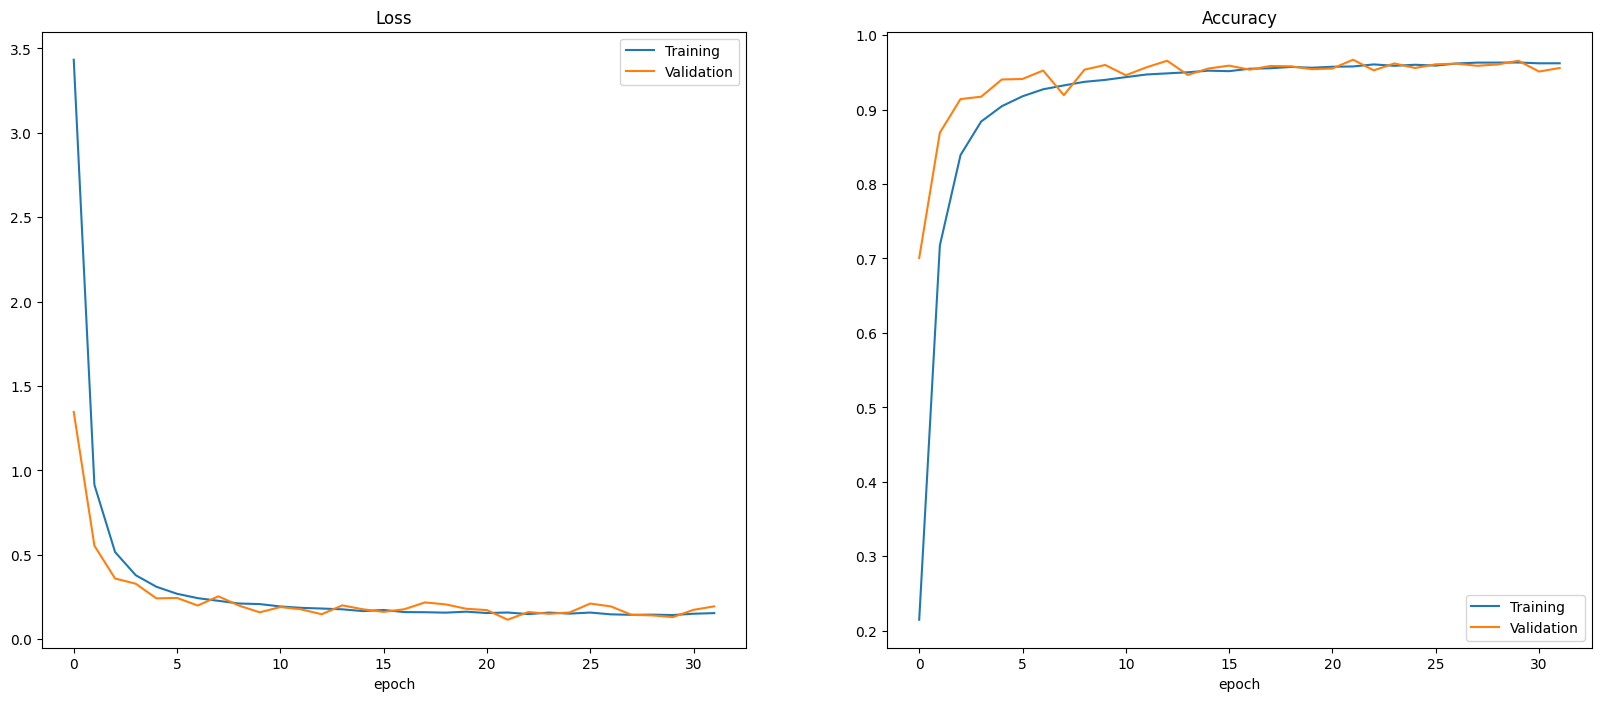

In [35]:
# model evaluation and plotting
evaluate_model(model2, X_test, y_test_onehot)
plot_history(history2)

In the beginning, the loss curve for both training and validation falls rapidly within the first few epochs.  
The rapid decrease shows that the model is learning from the training data by making proper adjustments in the weights to minimize the error rate.   
In the stabilization phase, it shows post-initial descent, and the loss curves in both training and validation loss approaches attain a stable state.   
The leveling off suggests that it has reached a point where further training doesn’t decrease the loss, meaning it’s already in an optimal learning state.  
For the accuracy plot, it improves immediately Corresponding to the initial drop in loss, there is a sharp increase in both training and validation accuracy.  
This rapid improvement indicates that the model is compatible with correctly classifying the training data. Training and validation accuracy increase initially with epochs and then both plateau to a good level.

1/1 [==============================] - 0s 44ms/step


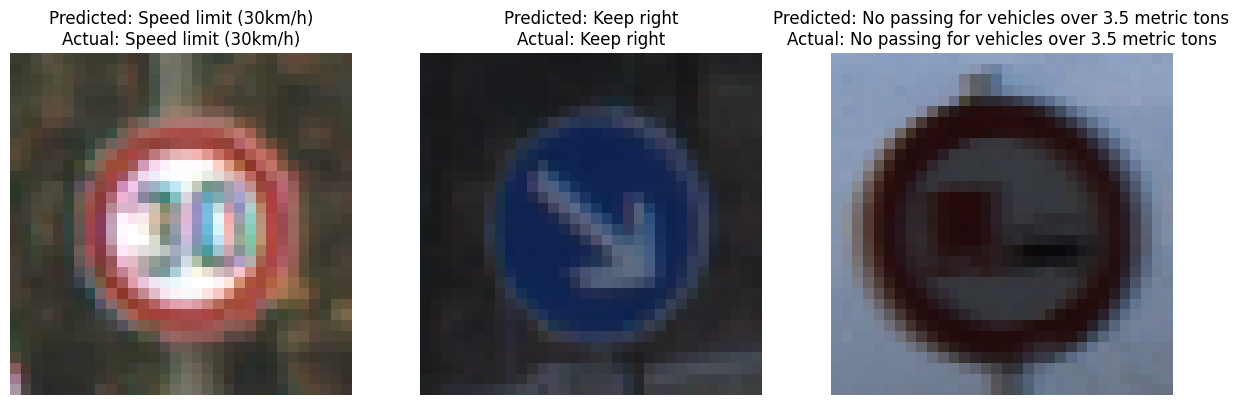

In [47]:
# test the model by predicting a random image
# Select three random images
test_indices = [random.randint(0, len(X_test) - 1) for _ in range(3)]
predictions = model2.predict(X_test[test_indices])
predicted_labels = np.argmax(predictions, axis=1)
labels = np.asarray(class_names["SignName"])

# Plot the images and their predicted labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[test_indices[i]])
    ax.set_title(f"Predicted: {labels[predicted_labels[i]]}\nActual: {class_names['SignName'][y_test[test_indices[i]]]}")
    ax.axis('off')

plt.show()

In [55]:
# check those uncorrect predictions shape
y_predicted = np.argmax(model2.predict(X_test), axis=1)
y_test_classes = test_data['labels']
wrong_predictions = test_data['features'][y_test_classes != y_predicted]
wrong_predictions.shape

395/395 [==============================] - 0s 922us/step


(492, 32, 32, 3)

There are 492 images are predicted wrong, lets find random 5 examples.

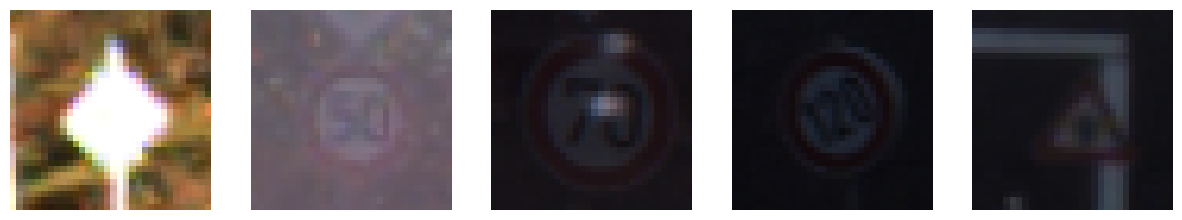

In [59]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    index = random.randint(0, len(wrong_predictions) - 1)
    axs[i].imshow(wrong_predictions[index])
    axs[i].axis("off")

plt.show()

End